In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the target network with frozen weights
class TargetNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TargetNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        # Freeze the weights
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        hidden = torch.sigmoid(self.fc1(x))
        output = torch.sigmoid(self.fc2(hidden))
        return hidden, output

# Define the copying model
class CopyingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CopyingModel, self).__init__()
        # Parameters for both layers
        self.weights1 = nn.Parameter(torch.randn(hidden_size, input_size))
        self.biases1 = nn.Parameter(torch.randn(hidden_size))
        
        self.weights2 = nn.Parameter(torch.randn(output_size, hidden_size))
        self.biases2 = nn.Parameter(torch.randn(output_size))

    def forward(self, x):
        # Linear transformations for two layers
        hidden = torch.sigmoid(x.mm(self.weights1.t()) + self.biases1)
        output = torch.sigmoid(hidden.mm(self.weights2.t()) + self.biases2)
        return hidden, output

# Parameters
input_size = 5  # For example
hidden_size = 10
output_size = 5
num_samples = 1000
learning_rate = 0.01
num_epochs = 500
lambda_hidden = 0.5  # Weight for hidden layer loss

# Generate random inputs
X = torch.randn(num_samples, input_size)

# Instantiate the target network
target_net = TargetNetwork(input_size, hidden_size, output_size)
with torch.no_grad():
    # Compute target activations
    hidden_targets, Y = target_net(X)

# Instantiate the copying model
copy_net = CopyingModel(input_size, hidden_size, output_size)

# Define the optimizer
optimizer = optim.Adam(copy_net.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    hidden_pred, output_pred = copy_net(X)
    
    # Compute loss for both the output and the hidden layer activations
    output_loss = nn.MSELoss()(output_pred, Y)
    hidden_layer_loss = nn.MSELoss()(hidden_pred, hidden_targets)
    
    # Total loss
    loss = output_loss + lambda_hidden * hidden_layer_loss
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {loss.item():.4f}, '
              f'Output Loss: {output_loss.item():.4f}, Hidden Loss: {hidden_layer_loss.item():.4f}')

# Evaluate weight matching for both layers
with torch.no_grad():
    target_weights1 = target_net.fc1.weight
    target_biases1 = target_net.fc1.bias
    estimated_weights1 = copy_net.weights1
    estimated_biases1 = copy_net.biases1

    weight_error1 = nn.MSELoss()(estimated_weights1, target_weights1)
    bias_error1 = nn.MSELoss()(estimated_biases1, target_biases1)

    target_weights2 = target_net.fc2.weight
    target_biases2 = target_net.fc2.bias
    estimated_weights2 = copy_net.weights2
    estimated_biases2 = copy_net.biases2

    weight_error2 = nn.MSELoss()(estimated_weights2, target_weights2)
    bias_error2 = nn.MSELoss()(estimated_biases2, target_biases2)

    print(f'Layer 1 - Weight MSE: {weight_error1.item():.6f}, Bias MSE: {bias_error1.item():.6f}')
    print(f'Layer 2 - Weight MSE: {weight_error2.item():.6f}, Bias MSE: {bias_error2.item():.6f}')


Epoch [100/500], Total Loss: 0.0236, Output Loss: 0.0022, Hidden Loss: 0.0426
Epoch [200/500], Total Loss: 0.0028, Output Loss: 0.0004, Hidden Loss: 0.0047
Epoch [300/500], Total Loss: 0.0008, Output Loss: 0.0003, Hidden Loss: 0.0009
Epoch [400/500], Total Loss: 0.0006, Output Loss: 0.0002, Hidden Loss: 0.0007
Epoch [500/500], Total Loss: 0.0005, Output Loss: 0.0002, Hidden Loss: 0.0006
Layer 1 - Weight MSE: 0.002369, Bias MSE: 0.000018
Layer 2 - Weight MSE: 0.238466, Bias MSE: 0.491721


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the target network with frozen weights
class TargetNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TargetNetwork, self).__init__()
        # Two fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        # Freeze the weights
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Define the copying model
class CopyingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CopyingModel, self).__init__()
        # These parameters will attempt to match the target weights and biases for both layers
        self.weights1 = nn.Parameter(torch.randn(hidden_size, input_size))
        self.biases1 = nn.Parameter(torch.randn(hidden_size))
        
        self.weights2 = nn.Parameter(torch.randn(output_size, hidden_size))
        self.biases2 = nn.Parameter(torch.randn(output_size))

    def forward(self, x):
        # Linear transformations for two layers
        x = torch.sigmoid(x.mm(self.weights1.t()) + self.biases1)
        x = torch.sigmoid(x.mm(self.weights2.t()) + self.biases2)
        return x

# Parameters
input_size = 5  # For example
hidden_size = 10
output_size = 5
num_samples = 1000
learning_rate = 0.01
num_epochs = 500

# Generate random inputs
X = torch.randn(num_samples, input_size)

# Instantiate the target network
target_net = TargetNetwork(input_size, hidden_size, output_size)
with torch.no_grad():
    # Compute target activations
    Y = target_net(X)

# Instantiate the copying model
copy_net = CopyingModel(input_size, hidden_size, output_size)

# Define the optimizer
optimizer = optim.Adam(copy_net.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = copy_net(X)
    loss = nn.MSELoss()(outputs, Y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate weight matching for both layers
with torch.no_grad():
    target_weights1 = target_net.fc1.weight
    target_biases1 = target_net.fc1.bias
    estimated_weights1 = copy_net.weights1
    estimated_biases1 = copy_net.biases1

    weight_error1 = nn.MSELoss()(estimated_weights1, target_weights1)
    bias_error1 = nn.MSELoss()(estimated_biases1, target_biases1)

    target_weights2 = target_net.fc2.weight
    target_biases2 = target_net.fc2.bias
    estimated_weights2 = copy_net.weights2
    estimated_biases2 = copy_net.biases2

    weight_error2 = nn.MSELoss()(estimated_weights2, target_weights2)
    bias_error2 = nn.MSELoss()(estimated_biases2, target_biases2)

    print(f'Layer 1 - Weight MSE: {weight_error1.item():.6f}, Bias MSE: {bias_error1.item():.6f}')
    print(f'Layer 2 - Weight MSE: {weight_error2.item():.6f}, Bias MSE: {bias_error2.item():.6f}')


Epoch [100/500], Loss: 0.0014
Epoch [200/500], Loss: 0.0003
Epoch [300/500], Loss: 0.0002
Epoch [400/500], Loss: 0.0001
Epoch [500/500], Loss: 0.0000
Layer 1 - Weight MSE: 0.346780, Bias MSE: 1.184428
Layer 2 - Weight MSE: 0.688563, Bias MSE: 0.561022


Epoch [1/50] - Train Loss: 0.092487, Test Loss: 0.074251
Epoch [2/50] - Train Loss: 0.067369, Test Loss: 0.069349
Epoch [3/50] - Train Loss: 0.064945, Test Loss: 0.064308
Epoch [4/50] - Train Loss: 0.064569, Test Loss: 0.064374
Epoch [5/50] - Train Loss: 0.063983, Test Loss: 0.063424
Epoch [6/50] - Train Loss: 0.063424, Test Loss: 0.062866
Epoch [7/50] - Train Loss: 0.062851, Test Loss: 0.062695
Epoch [8/50] - Train Loss: 0.062593, Test Loss: 0.062195
Epoch [9/50] - Train Loss: 0.062167, Test Loss: 0.061582
Epoch [10/50] - Train Loss: 0.061641, Test Loss: 0.061420
Epoch [11/50] - Train Loss: 0.061365, Test Loss: 0.061341
Epoch [12/50] - Train Loss: 0.061260, Test Loss: 0.060792
Epoch [13/50] - Train Loss: 0.060706, Test Loss: 0.061905
Epoch [14/50] - Train Loss: 0.060561, Test Loss: 0.063371
Epoch [15/50] - Train Loss: 0.060486, Test Loss: 0.061296
Epoch [16/50] - Train Loss: 0.059950, Test Loss: 0.060321
Epoch [17/50] - Train Loss: 0.060670, Test Loss: 0.058959
Epoch [18/50] - Train L

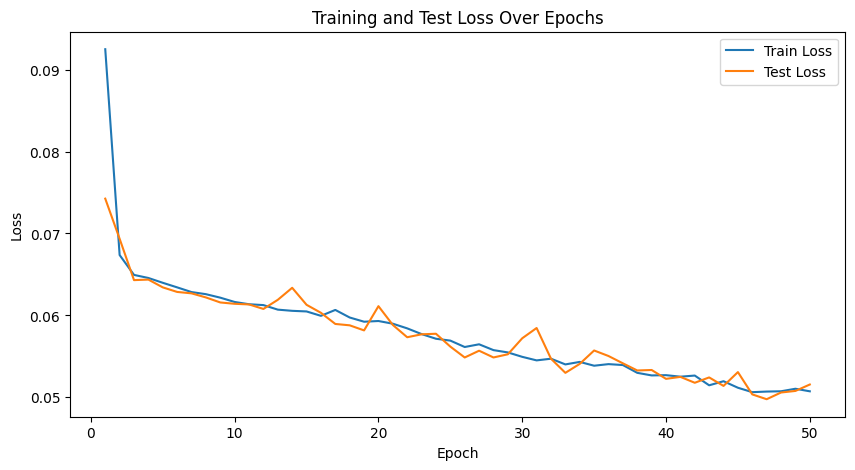

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Configurable Parameters
# ============================
seed = 42
use_subset = True  # Use a subset of the MNIST dataset for faster training
subset_size = 10000  # Size of the subset
batch_size = 256
epochs = 50
learning_rate = 1e-3

input_size = 28 * 28  # MNIST image size (28x28 flattened)
hidden_sizes_encoder = [512, 256, 128]
latent_size = 64  # Latent size (size of the middle layer)
hidden_sizes_decoder = [128, 256, 512]
output_size = 28 * 28  # Output size (same as input for autoencoder)
num_middle_layers = 100  # Number of frozen middle layers
# ============================

# Set random seed for reproducibility
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset preparation
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Use a subset for faster training
if use_subset:
    train_dataset = Subset(train_dataset, range(subset_size))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the autoencoder with multiple passes
class AutoencoderMultiplePasses(nn.Module):
    def __init__(self, input_size=784, hidden_sizes_encoder=[512, 256, 128],
                 latent_size=64, hidden_sizes_decoder=[128, 256, 512],
                 output_size=784, num_middle_layers=10):
        super(AutoencoderMultiplePasses, self).__init__()

        self.num_middle_layers = num_middle_layers

        # Encoder
        encoder_layers = []
        prev_size = input_size * 2  # Because we'll concatenate input and previous output
        for hidden_size in hidden_sizes_encoder:
            encoder_layers.append(nn.Linear(prev_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            prev_size = hidden_size
        self.encoder = nn.Sequential(*encoder_layers)

        # Middle layers (frozen and randomly swapped)
        self.middle_layers = nn.ModuleList()
        for _ in range(num_middle_layers):
            middle_layer = nn.Linear(prev_size, latent_size)
            nn.init.normal_(middle_layer.weight)
            nn.init.normal_(middle_layer.bias)
            for param in middle_layer.parameters():
                param.requires_grad = False  # Freeze the middle layer
            self.middle_layers.append(middle_layer)

        # Decoder
        decoder_layers = []
        prev_size = latent_size
        for hidden_size in hidden_sizes_decoder:
            decoder_layers.append(nn.Linear(prev_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            prev_size = hidden_size
        decoder_layers.append(nn.Linear(prev_size, output_size))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x, prev_output, middle_layer_idx):
        # Concatenate input and previous output
        if prev_output is None:
            combined_input = torch.cat((x, torch.zeros_like(x)), dim=1)  # First pass, no previous output
        else:
            combined_input = torch.cat((x, prev_output), dim=1)

        # Encode
        encoded = self.encoder(combined_input)

        # Pass through the randomly selected frozen middle layer
        middle = self.middle_layers[middle_layer_idx](encoded)

        # Decode
        decoded = self.decoder(middle)

        return decoded

# Training function
def train_model():
    model = AutoencoderMultiplePasses(
        input_size=input_size,
        hidden_sizes_encoder=hidden_sizes_encoder,
        latent_size=latent_size,
        hidden_sizes_decoder=hidden_sizes_decoder,
        output_size=output_size,
        num_middle_layers=num_middle_layers
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1, input_size).to(device)  # Flatten and move to device

            # Randomly select a middle layer for this batch
            middle_layer_idx = random.randint(0, num_middle_layers - 1)

            # First pass (prev_output is None)
            output1 = model(data, prev_output=None, middle_layer_idx=middle_layer_idx)

            # Second pass (use output from first pass)
            output2 = model(data, prev_output=output1.detach(), middle_layer_idx=middle_layer_idx)

            # Compute loss between final output and original input
            loss = criterion(output2, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)

        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Evaluation on test set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.view(-1, input_size).to(device)

                # Use the first middle layer for evaluation
                middle_layer_idx = 0

                # First pass
                output1 = model(data, prev_output=None, middle_layer_idx=middle_layer_idx)

                # Second pass
                output2 = model(data, prev_output=output1, middle_layer_idx=middle_layer_idx)

                loss = criterion(output2, data)
                test_loss += loss.item() * data.size(0)

        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

    return train_losses, test_losses

# Main training process
if __name__ == "__main__":
    train_losses, test_losses = train_model()

    # Visualization of Results
    epochs_range = range(1, epochs + 1)

    # Plot training and test losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.show()
